In [1]:
import os

# Set cache directories for XDG and Hugging Face Hub
os.environ['XDG_CACHE_HOME'] = '/home/msds2023/jlegara/.cache'
os.environ['HUGGINGFACE_HUB_CACHE'] = '/home/msds2023/jlegara/.cache'

In [2]:
import torch

# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from tqdm.notebook import tqdm

from moviepy.editor import VideoFileClip, ImageSequenceClip

import torch
from facenet_pytorch import (MTCNN)

from transformers import (AutoFeatureExtractor,
                          AutoModelForImageClassification,
                          AutoConfig)
                             
from PIL import Image, ImageDraw

In [30]:
# Load your video
four_sisters_video = 'four_sisters.mp4'
clip = VideoFileClip(four_sisters_video)

In [31]:
vid_fps = clip.fps
print(f"Video fps: {vid_fps}")

Video fps: 23.976023976023978


In [32]:
# Get the video (as frames)
video = clip.without_audio()
video_data = np.array(list(video.iter_frames()))

In [33]:
video_data.shape

(384, 720, 1280, 3)

In [34]:
def detect_emotions_single(image):
    """
    Detect emotions from a given image, displays the detected face and the emotion probabilities in a bar plot.

    Parameters:
    image (PIL.Image): The input image.

    Returns:
    PIL.Image: The cropped face from the input image.
    """
    
    # Create a copy of the image to draw on
    temporary = image.copy()

    # Use the MTCNN model to detect faces in the image
    sample = mtcnn.detect(temporary)

    # If a face is detected
    if sample[0] is not None:
        
        # Get the bounding box coordinates of the face
        box = sample[0][0]
        
        # Crop the detected face from the image
        face = temporary.crop(box)

        # Pre-process the cropped face to be fed into the emotion detection model
        inputs = extractor(images=face, return_tensors="pt")

        # Pass the pre-processed face through the model to get emotion predictions
        outputs = model(**inputs)

        # Apply softmax to the logits to get probabilities
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Retrieve the id2label attribute from the configuration
        id2label = AutoConfig.from_pretrained("trpakov/vit-face-expression").id2label

        # Convert probabilities tensor to a Python list
        probabilities = probabilities.detach().numpy().tolist()[0]

        # Map class labels to their probabilities
        class_probabilities = {id2label[i]: prob for i,
                               prob in enumerate(probabilities)}

        # Define colors for each emotion
        colors = {
            "angry": "red",
            "disgust": "green",
            "fear": "gray",
            "happy": "yellow",
            "neutral": "purple",
            "sad": "blue",
            "surprise": "orange"
        }
        palette = [colors[label] for label in class_probabilities.keys()]

        # Prepare a figure with 2 subplots: one for the face image, one for the bar plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        # Display the cropped face in the left subplot
        axs[0].imshow(np.array(face))
        axs[0].axis('off')

        # Create a horizontal bar plot of the emotion probabilities in the right subplot
        sns.barplot(ax=axs[1],
                    y=list(class_probabilities.keys()),
                    x=[prob * 100 for prob in class_probabilities.values()],
                    palette=palette,
                    orient='h')
        axs[1].set_xlabel('Probability (%)')
        axs[1].set_title('Emotion Probabilities')
        axs[1].set_xlim([0, 100])  # Set x-axis limits to show percentages

        # Show the plot
        plt.show()

In [35]:
# Initialize MTCNN model for single face cropping
mtcnn = MTCNN(
    image_size=160,
    margin=0,
    min_face_size=200,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=True,
    keep_all=False,
    device=device
)
    
# Load the pre-trained model and feature extractor
extractor = AutoFeatureExtractor.from_pretrained("trpakov/vit-face-expression")
model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

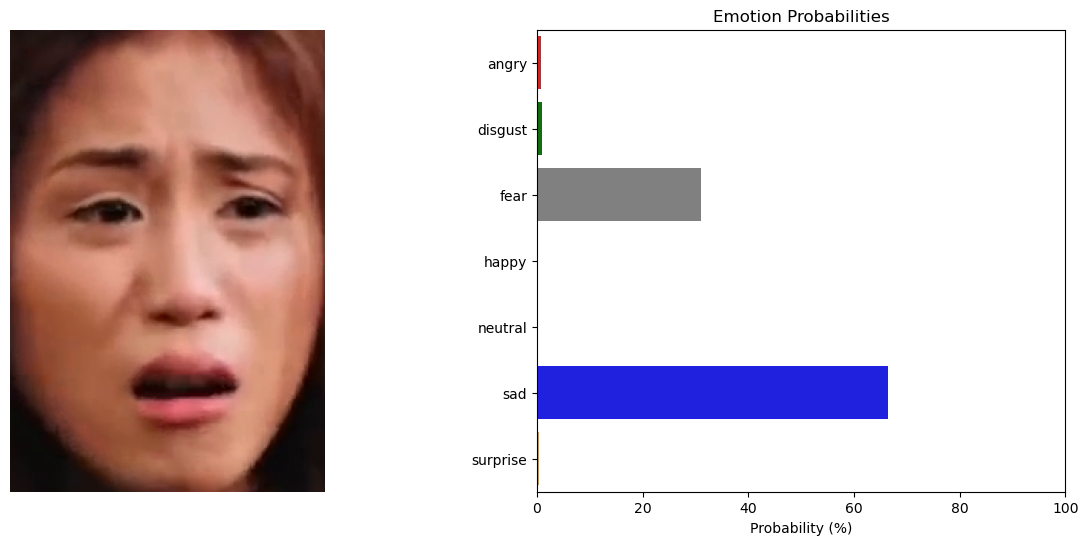

In [36]:
# Choose a frame
frame = video_data[50]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)
detect_emotions_single(image)

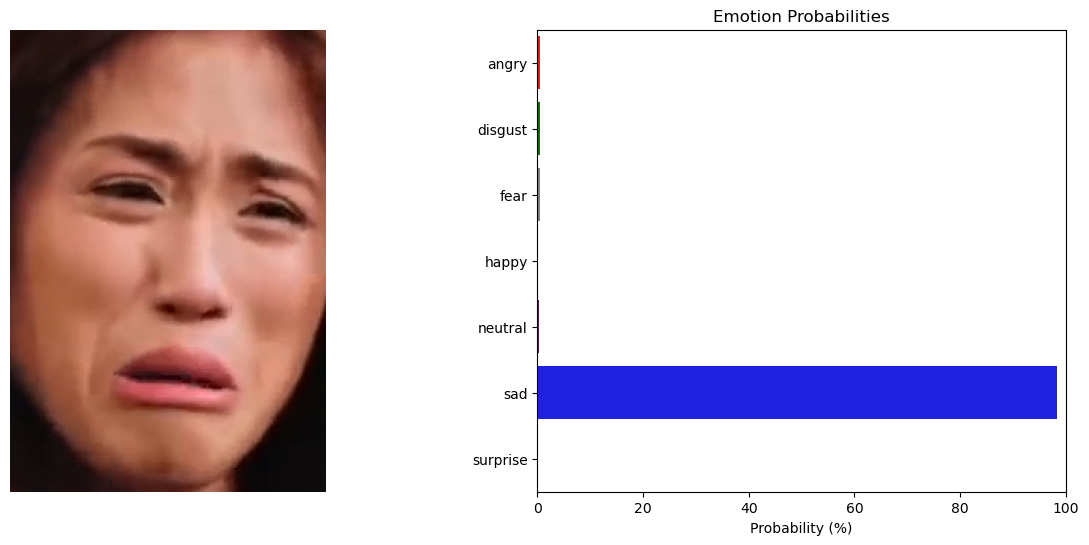

In [37]:
# Choose a frame
frame = video_data[100]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)
detect_emotions_single(image)

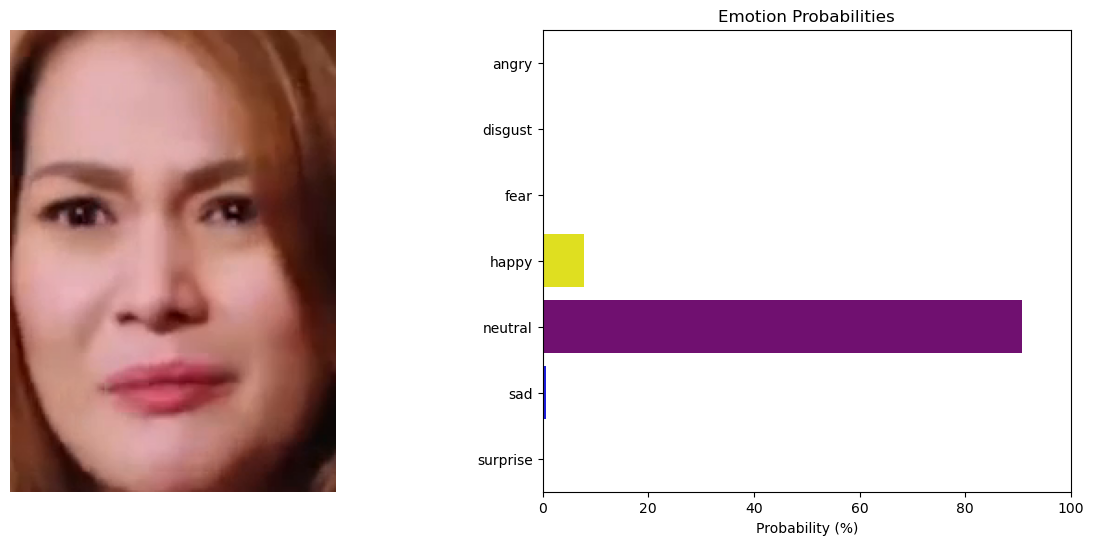

In [38]:
# Choose a frame
frame = video_data[320]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)
detect_emotions_single(image)

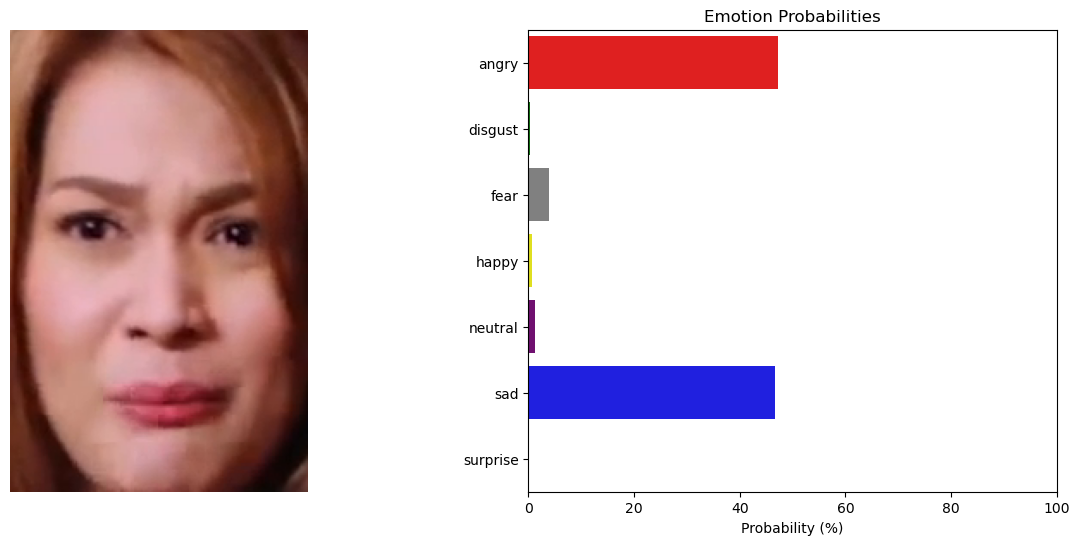

In [39]:
# Choose a frame
frame = video_data[350]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)
detect_emotions_single(image)

In [14]:
def detect_emotions(image):
    """
    Detect emotions from a given image.
    Returns a tuple of the cropped face image and a
    dictionary of class probabilities.
    """
    temporary = image.copy()

    # Detect faces in the image using the MTCNN group model
    sample = mtcnn.detect(temporary)
    if sample[0] is not None:
        box = sample[0][0]

        # Crop the face
        face = temporary.crop(box)

        # Pre-process the face
        inputs = extractor(images=face, return_tensors="pt")

        # Run the image through the model
        outputs = model(**inputs)

        # Apply softmax to the logits to get probabilities
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Retrieve the id2label attribute from the configuration
        config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
        id2label = config.id2label

        # Convert probabilities tensor to a Python list
        probabilities = probabilities.detach().numpy().tolist()[0]

        # Map class labels to their probabilities
        class_probabilities = {
            id2label[i]: prob for i, prob in enumerate(probabilities)
        }

        return face, class_probabilities
    return None, None

In [15]:
def create_combined_image(face, class_probabilities):
    """
    Create an image combining the detected face and a barplot
    of the emotion probabilities.

    Parameters:
    face (PIL.Image): The detected face.
    class_probabilities (dict): The probabilities of each
        emotion class.

    Returns:
    np.array: The combined image as a numpy array.
    """
    # Define colors for each emotion
    colors = {
        "angry": "red",
        "disgust": "green",
        "fear": "gray",
        "happy": "yellow",
        "neutral": "purple",
        "sad": "blue",
        "surprise": "orange"
    }
    palette = [colors[label] for label in class_probabilities.keys()]
    
    # Create a figure with 2 subplots: one for the face image, one for the barplot
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Display face on the left subplot
    axs[0].imshow(np.array(face))
    axs[0].axis('off')

    # Create a barplot of the emotion probabilities on the right subplot
    sns.barplot(ax=axs[1],
                y=list(class_probabilities.keys()),
                x=[prob * 100 for prob in class_probabilities.values()],
                palette=palette,
                orient='h')
    axs[1].set_xlabel('Probability (%)')
    axs[1].set_title('Emotion Probabilities')
    axs[1].set_xlim([0, 100])  # Set x-axis limits

    # Convert the figure to a numpy array
    canvas = FigureCanvas(fig)
    canvas.draw()
    img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    img  = img.reshape(canvas.get_width_height()[::-1] + (3,))
    
    plt.close(fig)
    return img

In [16]:
skips = 1
reduced_video = []

for i in tqdm(range(0, len(video_data), skips)):
    reduced_video.append(video_data[i])

  0%|          | 0/384 [00:00<?, ?it/s]

In [17]:
# Define a list of emotions
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# List to hold the combined images
combined_images = []

# Create a list to hold the class probabilities for all frames
all_class_probabilities = []

# Loop over video frames
for i, frame in tqdm(enumerate(reduced_video),
                     total=len(reduced_video),
                     desc="Processing frames"):
    # Convert frame to uint8
    frame = frame.astype(np.uint8)

    # Call detect_emotions to get face and class probabilities
    face, class_probabilities = detect_emotions(Image.fromarray(frame))
    
    # If a face was found
    if face is not None:
        # Create combined image for this frame
        combined_image = create_combined_image(face, class_probabilities)
        
        # Append combined image to the list
        combined_images.append(combined_image)
    else:
        # If no face was found, set class probabilities to None
        class_probabilities = {emotion: None for emotion in emotions}
        
    # Append class probabilities to the list
    all_class_probabilities.append(class_probabilities)

Processing frames:   0%|          | 0/384 [00:00<?, ?it/s]

In [18]:
# Convert list of images to video clip
clip_with_plot = ImageSequenceClip(combined_images,
                                   fps=vid_fps/skips)  # Choose the frame rate (fps) according to your requirement

# Display the clip
clip_with_plot.ipython_display(width=900)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## That Thing Called Tadhana

In [40]:
# Load your video
that_thing_video = 'that_thing_called_tadhana.mp4'
clip = VideoFileClip(that_thing_video)

In [41]:
vid_fps = clip.fps
print(f"Video fps: {vid_fps}")

Video fps: 23.976023976023978


In [42]:
# Get the video (as frames)
video = clip.without_audio()
video_data = np.array(list(video.iter_frames()))

In [43]:
video_data.shape

(1355, 720, 1280, 3)

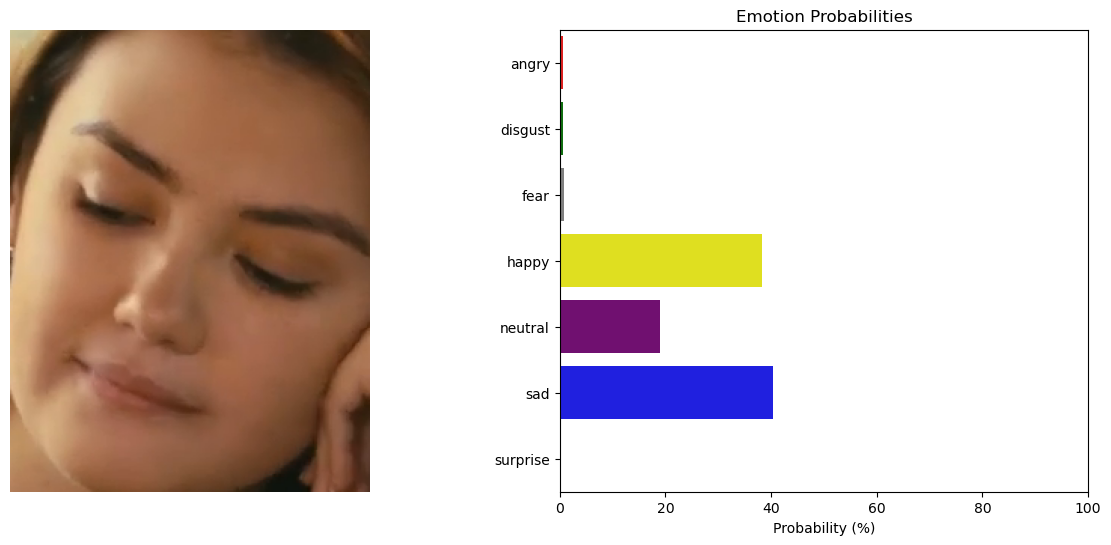

In [52]:
# Choose a frame
frame = video_data[200]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)
detect_emotions_single(image)

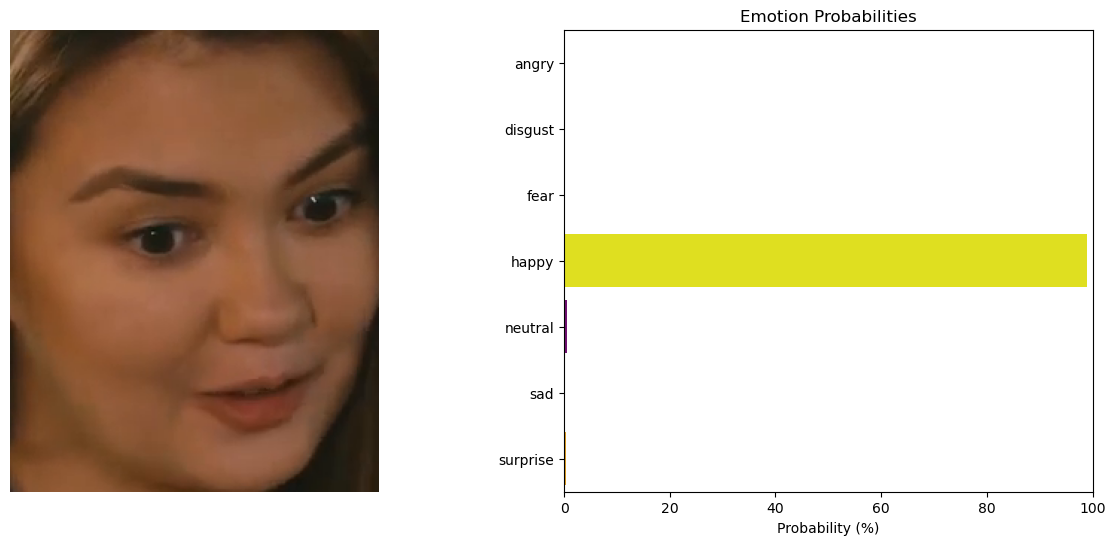

In [57]:
# Choose a frame
frame = video_data[550]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)
detect_emotions_single(image)

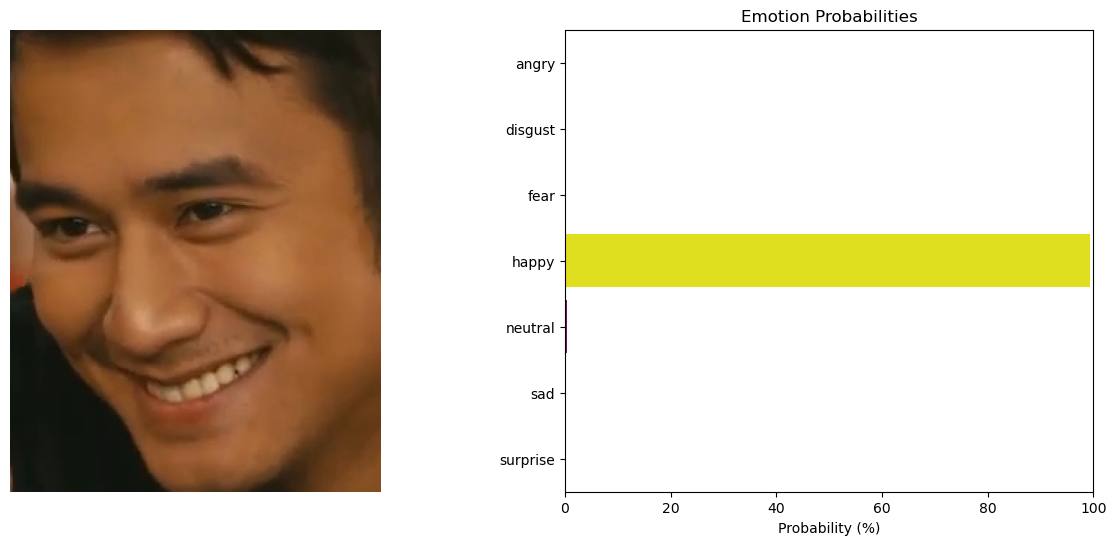

In [60]:
# Choose a frame
frame = video_data[620]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)
detect_emotions_single(image)

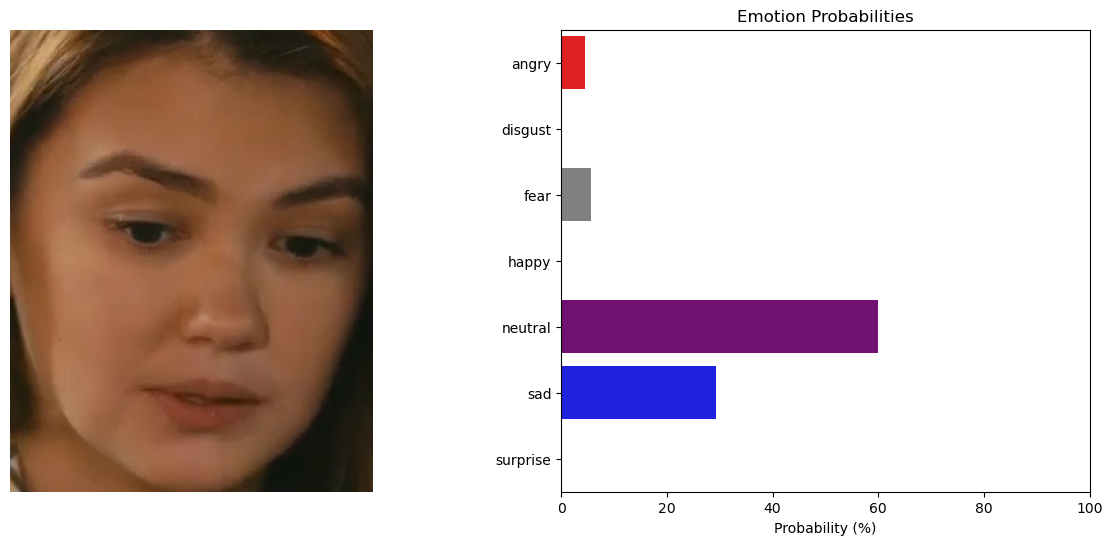

In [62]:
# Choose a frame
frame = video_data[750]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)
detect_emotions_single(image)